# 프로젝트 : 폐렴 진단기 성능개선
### 개요
pneumonia_segmentation.ipynb 파일에서 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.  
그러나 90% 이상에 도달하는 숙련된 의사분들 유사한 성능을 내기 위하여 모델 성능을 향상시켜보려 합니다.  
### 목차
1. 실험환경 Set-up
2. 데이터 준비하기
3. 데이터 시각화
4. ResNet-18 구현
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화

### 회고

### 참조
---

우선 주요 라이브러리 버전을 확인해 보겠습니다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [2]:
# 패키지(라이브러리)들을 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 앞으로 필요한 변수들을 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# epochs을 10 -> 8로 조정
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
데이터는 아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

- train
    - NORMAL
    - PNEUMONIA
- test
    - NORMAL
    - PNEUMONIA
- val
    - NORMAL
    - PNEUMONIA

In [4]:
# train, test, validation 각 데이터들의 개수 확인하기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # TRAIN_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
test_filenames = tf.io.gfile.glob(TEST_PATH)   # TEST_PATH 내의 모든 파일에 대한 리스트를 반환하여 test_filenames 변수에 할당
val_filenames = tf.io.gfile.glob(VAL_PATH)   # VAL_PATH 내의 모든 파일에 대한 리스트를 반환하여 val_filenames 변수에 할당

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
- 개수 비율은 89%, 10.7%, 0.3% 로 val개수가 너무 적기 때문에 train에서 val에 쓰일 데이터를 더 가져옵니다.
- train, val 데이터를 모은 후 train:val = 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)   # 전체 데이터셋에서 80%에 해당하는 훈련 데이터의 크기를 계산. math.floor 함수를 사용하여 소수점 이하를 버림.
random.seed(8)                                # 난수 발생 시드를 8로 설정합니다. 이는 난수 생성의 초기 상태를 지정하는데 사용됨.
random.shuffle(filenames)                     # 리스트 내의 파일 경로들을 무작위로 섞기
train_filenames = filenames[:train_size]      # 섞인 리스트에서 처음부터 훈련 데이터의 크기까지를 선택하여 훈련 데이터셋으로 지정
val_filenames = filenames[train_size:]        # 나머지 부분을 검증 데이터셋으로 지정

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- 80:20으로 분할 결과 train은 4185개, test는 624개, val은 1047개가 되었습니다.
- test_size를 수정하면 개수는 달라질 수 있습니다.

In [7]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인하기
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


- 정상 이미지와 폐렴 이미지의 구분은 파일 경로로 알 수 있습니다. : NORMAL, PNEUMONIA
- 즉, 정상 이미지와 폐렴 이미지의 개수는 파일 경로에 각각 NORMAL, PNEUMONIA이 있는지 확인하면 셀 수 있습니다.

In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과 해석하기

- 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.
- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다.
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.
- test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.  

tf.data 인스턴스를 만들기
- tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [10]:
# train_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 훈련 데이터셋을 만듭니다.
# val_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 검증 데이터셋을 만듭니다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# Train 데이터셋, validation 데이터셋의 크기(이미지 개수) 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없습니다.
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄입니다.  

- decode_img 함수와 process_path 함수를 만들겠습니다.
    - process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다.
    - get_label을 이용해서 라벨 값을 가져옵니다.

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.

- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

Image shape:  (180, 180, 3)
Label:  False


- train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다.
- 그리고 데이터 개수도 확인하겠습니다.

In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()   # test 데이터셋의 크기(이미지 개수) 확인
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)       # 이미지 파일의 경로를 입력하여 이미지와 라벨을 읽기
test_ds = test_ds.batch(BATCH_SIZE)   # 데이터셋을 배치 단위로 묶기

print(TEST_IMAGE_COUNT)

624


의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 따라서 augmentation 기법을 활용해보고자 합니다.   
그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다.   
특히 X-RAY 같은 의료 영상의 특성 상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.  
그래서 augmentation 도입은 신중해야 합니다.

- 다음은 좌우 반전과 밝기 조정 augmentation 함수를 생성하여 도입하는 과정입니다.

In [17]:
# 좌우 반전 augmentation
def augment1(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label


# 밝기 조정 augmentation
def augment2(image,label):
    image = tf.image.adjust_brightness(image, 0.1)  
    return image,label

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.  

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데,  
이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.  
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.  
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.  

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,  
첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment1,       # augment1(좌우 반전) 함수 적용
        num_parallel_calls=2
    )
    ds = ds.map(
        augment2,       # augment2(밝기 조정) 함수 적용
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.  
좌우 반전과 밝기 조정 augmentation이 제대로 처리되었는지를 show_batch() 함수를 통해 확인해 봅니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

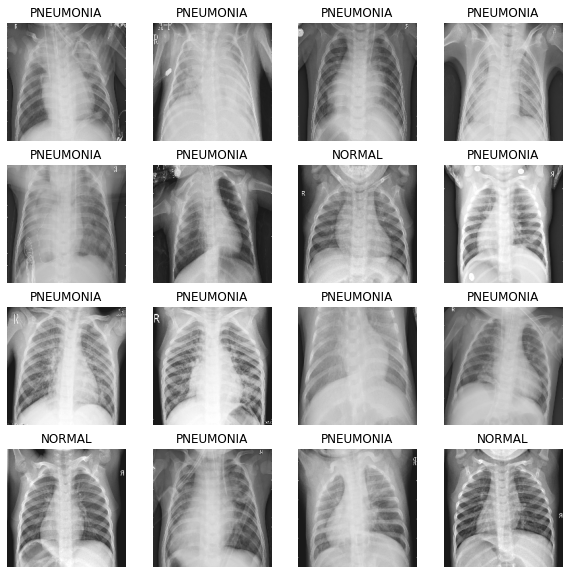

In [19]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)   # math.ceil(BATCH_SIZE/4)는 배치 크기를 4로 나눈 결과를 올림하여 필요한 행의 수를 계산
        plt.imshow(image_batch[n])   # 현재 서브플롯에 이미지를 표시
        
        # 현재 이미지에 대한 라벨이 참(True)이면 ("PNEUMONIA"), 그렇지 않으면 ("NORMAL")으로 설정
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


# 훈련 데이터셋으로부터 하나의 배치를 가져오기 - iter(train_ds)로부터 next 함수를 사용하여 다음 배치를 추출
image_batch, label_batch = next(iter(train_ds))
# show_batch 함수를 사용하여 훈련 데이터셋의 일부 이미지를 시각화
show_batch(image_batch.numpy(), label_batch.numpy())

좌우 반전
- 이미지 내의 R표시는 원본 이미지의 경우 좌측에 있습니다.  
- R표시가 우측에 있는 이미지들이 발견되므로 좌우 반전이 적용된 것을 확인할 수 있습니다.  

밝기 조정
- 밝기 조정으로 오히려 장기와 뼈, 폐 영역의 구분이 원본에 비해 모호해졌습니다.
- 성능에 좋은 영향을 미치지 못할 것으로 예상되어 prepare_for_training 함수에서 밝기 조정은 제외하고 진행하겠습니다.

In [20]:
# 좌우 반전 증강만 적용
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment1,       # augment1(좌우 반전) 함수 적용
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.   
Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다.   
ResNet-18은 ResNet의 가장 작은 버전입니다.   

ResNet은 Residual block을 먼저 구성해야 합니다.   
ResNet에서의 weight layer는 아래와 같이 구성되어 있습니다.

1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU  

![Residual Block](https://d3s0tskafalll9.cloudfront.net/media/images/residual_connection.max-800x600.png)  

In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from typing import Any, Callable, List, Optional, Type

ModuleNotFoundError: No module named 'einops'

In [24]:
# 라이브러리 불러오는 중 오류 발생. einops 패키지 설치
!pip install einops

     |████████████████████████████████| 44 kB 2.5 MB/s             


In [25]:
# 라이브러리 불러오기
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from typing import Any, Callable, List, Optional, Type

ModuleNotFoundError: No module named 'torchsummary'

In [26]:
# torchsummary 패키지 설치
!pip install torchsummary

In [27]:
# 라이브러리 불러오기
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from typing import Any, Callable, List, Optional, Type

**Residual Block 만들기**

In [29]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

- in_planes : 입력 필터개수
- out_planes : 출력 필터개수
- groups : input과 output의 connection을 제어하며 1이 기본값입니다.
- dilation : 커널 원소간의 거리입니다. 늘릴수록 같은 파라미터수로 더 넓은 범위를 파악할 수 있게 됩니다. 기본값인 1을 계속 사용하려 합니다.

**Residual Block의 전체코드**

In [30]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        
        # Normalization Layer
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # downsampling이 필요한 경우 downsample layer를 block에 인자로 넣어주어야함
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # residual connection
        out = self.relu(out)

        return out

In [37]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

**ResNet Class 전체 코드**  
이미지와 같은 Residual block을 구성한 후, 아래와 같이 ResNet을 구현합니다.   
(참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿀 예정입니다.)   
![ResNet 구현](https://d3s0tskafalll9.cloudfront.net/media/images/resnet-18.max-800x600.png)

In [39]:
from typing import Union

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer  # batch norm layer

        self.inplanes = 64  # input shape
        self.dilation = 1  # dilation fixed
        self.groups = 1  # groups fixed
        
        # input block
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=False)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=False)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        
        # downsampling 필요할경우 downsample layer 생성
        if stride != 1 or self.inplanes != planes:  
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.dilation, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                 dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        print('input shape:', x.shape)
        x = self.conv1(x)
        print('conv1 shape:', x.shape)
        x = self.bn1(x)
        print('bn1 shape:', x.shape)
        x = self.relu(x)
        print('relu shape:', x.shape)
        x = self.maxpool(x)
        print('maxpool shape:', x.shape)

        x = self.layer1(x)
        print('layer1 shape:', x.shape)
        x = self.layer2(x)
        print('layer2 shape:', x.shape)
        x = self.layer3(x)
        print('layer3 shape:', x.shape)
        x = self.layer4(x)
        print('layer4 shape:', x.shape)

        x = self.avgpool(x)
        print('avgpool shape:', x.shape)
        x = torch.flatten(x, 1)
        print('flatten shape:', x.shape)
        x = self.fc(x)
        print('fc shape:', x.shape)

        return x

> 구글링하여 ResNet 코드를 활용해보려 하였으나 제대로 이해하지는 못하였습니다.  
> 직접 ResNet 코드를 작성해보기로 하였습니다.

In [28]:
# 라이브러리 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

- skip connection이 구현된 함수 residual_module을 정의

In [32]:
def residual_module(input_layer, n_filters):
    merge_input = input_layer

# if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer)
    # Conv2D layer
    conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    # BatchNomalizaiont
    bn1 = keras.layers.BatchNormalization()(conv1)
    # relu layer
    relu = keras.layers.Activation('relu')(bn1)
    # Conv2D layer
    conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(relu)
    # BatchNomalizaiont
    bn2 = keras.layers.BatchNormalization()(conv2)

    # Add를 통해서 skip connection을 구현하는 부분
    out_layer = keras.layers.Add()([conv2, merge_input])
    out_layer = keras.layers.Activation('relu')(out_layer)

    return out_layer

In [34]:
# Input layer 정의 및 residual module 생성

input = keras.layers.Input(shape=(180, 180, 1))
residual_out = residual_module(input, 64)

In [35]:
print(residual_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 64), dtype=tf.float32, name=None), name='activation_1/Relu:0', description="created by layer 'activation_1'")


> residual module을 여러 개 연결하여 ResNet18 모델을 구현하는 방법을 찾지 못하였습니다.
> 이후 과정은 구글링한 모델로 진행하였습니다.

# Step 5. 데이터 imbalance 처리
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었습니다.  
한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.  

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다.  
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.  
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.  

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다.  
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [40]:
# 가중치 = (1/클래스의 샘플 수) x 총 샘플 수 / 2.0
# 1/2.0을 곱해주는 이유는 가중치를 상대적으로 줄이기 위함 -> 만약 이 부분이 없다면, 특히 불균형이 심한 경우에는 어떤 클래스의 샘플이 많아서 그 쪽으로 편향된 학습이 이루어질 수 있다.
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# 클래스 0과 클래스 1에 대한 가중치를 딕셔너리로 저장. 이 가중치는 모델 학습 시 사용.
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


- 생각해보기  
    - 만약 imbalance 처리를 생략한다면 어떻게 될까?  
        - 학습 자체가 제대로 이뤄지지 않거나, 과적합이 될 것이라 예상된다.
    - 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까?
        - 이미 정답인 것을 맞추는 recall을 강조하는 것이 의미있는 액션일까? 하는 의문이 든다.
        - 더 강화하는 효과가 있다면 무엇일지 궁금하다.

# Step 6. 모델 훈련
- 이미지 훈련에 GPU를 사용합니다.
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다.
- 성능 향상을 위해 optimizer나 learning rate 등의 변화를 고려해볼 수 있습니다.

In [41]:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)

SyntaxError: invalid syntax (310616049.py, line 2)

In [42]:
model = ResNet(BasicBlock, [2, 2, 2, 2])
x = torch.randn(1, 3, 112, 112)
print('\noutput shape:', model(x).shape)

input shape: torch.Size([1, 3, 112, 112])
conv1 shape: torch.Size([1, 64, 56, 56])
bn1 shape: torch.Size([1, 64, 56, 56])
relu shape: torch.Size([1, 64, 56, 56])
maxpool shape: torch.Size([1, 64, 28, 28])
layer1 shape: torch.Size([1, 64, 28, 28])
layer2 shape: torch.Size([1, 128, 14, 14])
layer3 shape: torch.Size([1, 256, 7, 7])
layer4 shape: torch.Size([1, 512, 4, 4])
avgpool shape: torch.Size([1, 512, 1, 1])
flatten shape: torch.Size([1, 512])
fc shape: torch.Size([1, 1000])

output shape: torch.Size([1, 1000])


# Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅니다.   
우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.   
훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해봅니다.

---

## 회고
### KEEP
- 과정(흐름) 자체는 대략적으로 이해하였다.
- 데이터 증강(좌우 반전, 밝기 조정)을 시도해보고, 적절한 것만 남겼다.
- 해결이 어려운 코드를 구글링하고 적용해보며 모델 완성을 시도하였다.

### PROBLEM
- ResNet 구현 자체가 어렵고, 어디서부터 어떻게 해야할지 아예 감이 잡히지 않았다.
- 노드학습에서 배운 방식대로 데이터 전처리를 한 이후 구글링으로 모델 코드를 참조할 때 어떻게 적용해야할지 모르겠다.

### TRY
- ResNet 구현과 구글링한 코드 적용하는 방법과 관련하여   
퍼실님, 그루분들, 친구 등에 도움을 요청하여 내 코드를 같이 보면서 수정 및 작성해보는 연습 해보기.

---

### Reference
- ResNet 
    - ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.
    - ResNet의 특징은 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. 
    ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.   
    
- ResNet18 모델 참조 블로그
    - [ResNet18 파이토치 코드리뷰](https://yhkim4504.tistory.com/3)
    - [ResNet18 코드 구현](https://haystar.tistory.com/94)
    - [폐렴 진단 베이스라인 모델과 성능 개선](https://gongboogi.tistory.com/15)
    - [ResNet 개념](https://coding-yoon.tistory.com/141)
    - [ResNet](https://www.slideshare.net/DataScienceLab/ss-249899490)
    - [구현1](https://github.com/Woodywarhol9/aiffel/blob/main/Exploration/project/%5BE11%5Dpneumonia_detection_pjt.ipynb)
    - [구현2](https://velog.io/@och9854/E-09-Pneumonia)
- [텐서플로우 데이터 증강](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)